Let's first load the necessary packages and libraries

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from Graph_Generation.simple_graph_generation import create_delaunay_graph
from Graph_Generation.target_graph import create_fully_connected_target_graph
from Graph_Generation.visibility import two_hop_visibility
from Graph_Generation.edge_block_generation import block_edge_on_path, block_edges_maintain_connectivity
from Single_Agent.repeated_topk import RepeatedTopK

Let's generate the graph (a 2D denaunay graph)


At the moment we have the following graph features


Node Level: 

- "type": "source", "target_unreached", "target_reached", "intermediate" 

- "visible_edges": a map from each node to the visible edges 

- 'pos' : a 2D tuple of the nodes' position


Edge Level: 

- "distance": Euclidian distance of the edge 

- "observed_edge" : boolean of whether or not the edge was observed 
    
- "num_used" : an edge value function 

- "blocked" : a boolean denoting the blockage of an edge

In [2]:
num_nodes = 64
env_graph = create_delaunay_graph(64, target_ratio = 4/64, seed = 87)
_ = two_hop_visibility(env_graph, num_extended_nodes=3, node_list=list([5, 41, 47]))
target_graph = create_fully_connected_target_graph(env_graph)

Let's first visualize the environment graph

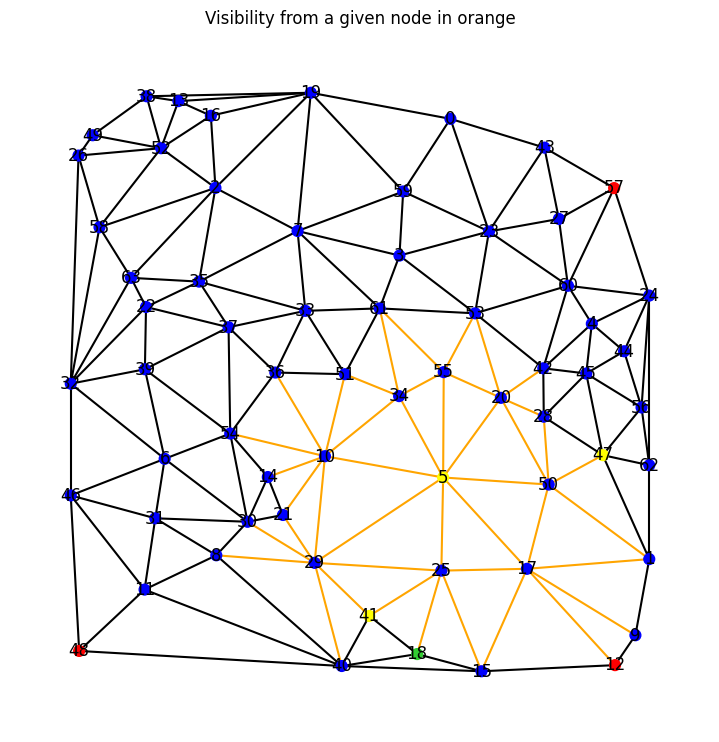

In [3]:
extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', True)]
non_extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', False)]

source_node = extended_nodes[0] if extended_nodes else non_extended_nodes[0]
visible_edges = env_graph.nodes[source_node]['visible_edges']

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in visible_edges:
        # Style for visible edges: orange
        edge_color.append('orange')
    else:
        # Style for invisible edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=True,
    node_size=60,
    width=1.5,
    edge_color=edge_color
)

plt.title("Visibility from a given node in orange")
plt.show()

Let's also visulize the target graph and the 'num_used' weights

The target graph is a simpler graph made of only the target nodes. The edges are generated by connecting the 4 closest neighbors.

The target graph feature are

Node Level: 

- "type": "source", "target_unreached", "target_reached", "intermediate" 

- 'pos' : a 2D tuple of the nodes' position


Edge Level: 

- 'distance': Shortest Path length between the two target nodes

- 'diverse_paths' : A list containing 3 of the shortest diverse paths between the two targets 

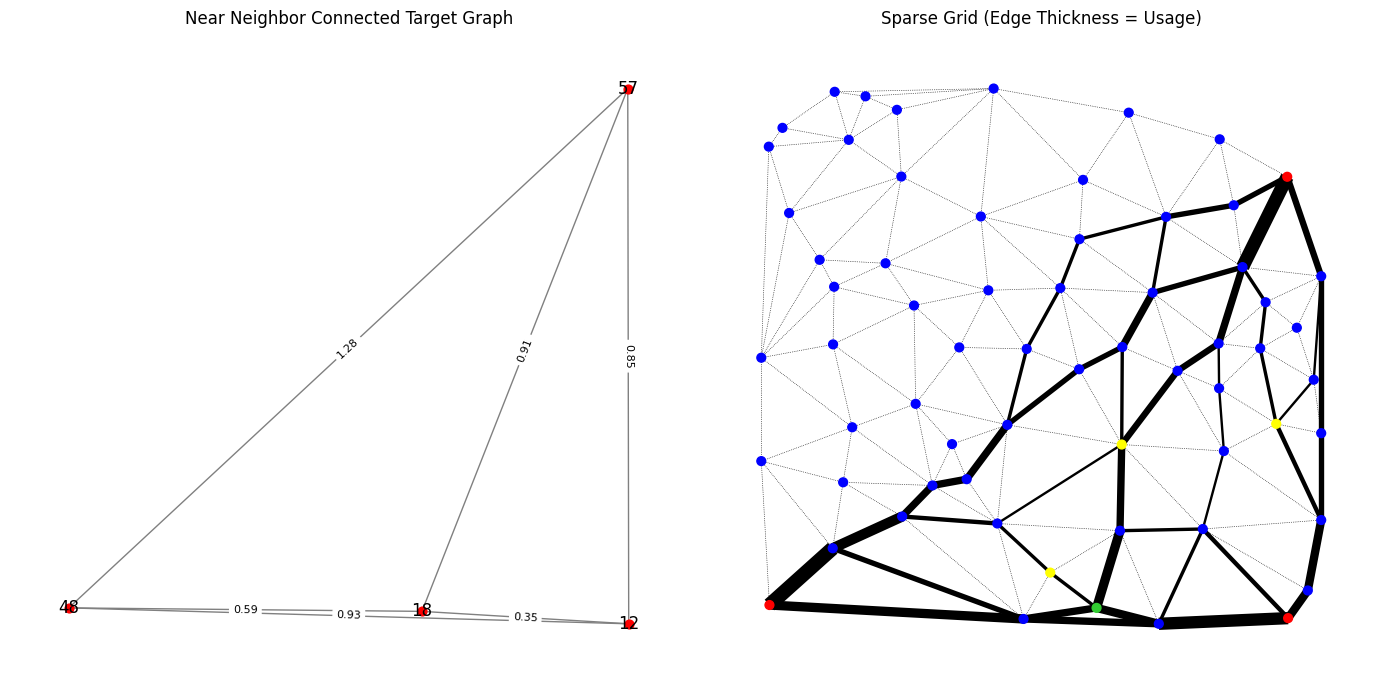

In [4]:
# --- 1. Prepare for Plotting ---

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', True)]

color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")   
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_labels = {}
for u, v, data in target_graph.edges(data=True):
    distance = data['distance']
    edge_labels[(u, v)] = f"{distance:.2f}"

# --- 2. Create Dynamic Edge Styles for the Sparse Grid ---

edge_widths = []
edge_styles = []
for u, v, data in env_graph.edges(data=True):
    num_used = data.get('num_used', 0)
    if num_used > 0:
        # Style for used edges: solid and thicker based on usage count
        edge_styles.append('solid')
        edge_widths.append(1.0 + 5.0 * num_used)  # Scaled for visibility
    else:
        # Style for unused edges: dotted and thin
        edge_styles.append('dotted')
        edge_widths.append(0.5)

# --- 3. Create the Side-by-Side Plot (in the new order) ---

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# --- Plot 1: Fully Connected Target Graph (NOW on the left axis) ---
axes[0].set_title("Near Neighbor Connected Target Graph")
nx.draw(
    target_graph,
    pos=pos,
    ax=axes[0],  # Draw on the left subplot
    node_color="red",
    with_labels=True,
    node_size=40,
    width=1.0,
    edge_color='grey'
)

nx.draw_networkx_edge_labels(
    target_graph, 
    pos=pos,
    ax =axes[0],
    edge_labels=edge_labels,
    font_size=8
)

# --- Plot 2: Original Sparse Grid with Usage (NOW on the right axis) ---
axes[1].set_title("Sparse Grid (Edge Thickness = Usage)")
nx.draw(
    env_graph,
    pos=pos,
    ax=axes[1],  # Draw on the right subplot
    node_color=color_map,
    with_labels=False,
    node_size=40,
    width=edge_widths,  # Use the dynamic widths
    style=edge_styles   # Use the dynamic styles
)

plt.tight_layout()
plt.show()

Before we created the blocked edge environment, let's instantiate the path generator. This will be used to figure out the shortest path based on distance. (We will be blocking edges on this path)

In [5]:
path_generator = RepeatedTopK(reward_ratio = 1.0, env_graph=env_graph, target_graph=target_graph)

shortest_path = []
hamiltonian_target_path = path_generator.generate_Hamiltonian_path()
for i in range(len(hamiltonian_target_path) - 1):
    begin_node = hamiltonian_target_path[i]
    end_node = hamiltonian_target_path[i + 1]

    section_path = nx.shortest_path(env_graph, source=begin_node, target=end_node, weight="distance")

    # Append the section best path, avoiding duplication of nodes at the end
    if len(shortest_path) > 0 and shortest_path[-1] == section_path[0]:
        shortest_path.extend(section_path[1:])
    else:
        shortest_path.extend(section_path)

TSP Cycle: [12, 18, 48, 57]


Let's now block some of the edges on the graph. 

Here we will use a simple method of just blocking one edge per section (a section being a subpath between two target). Basically, one blocked edge between two targets

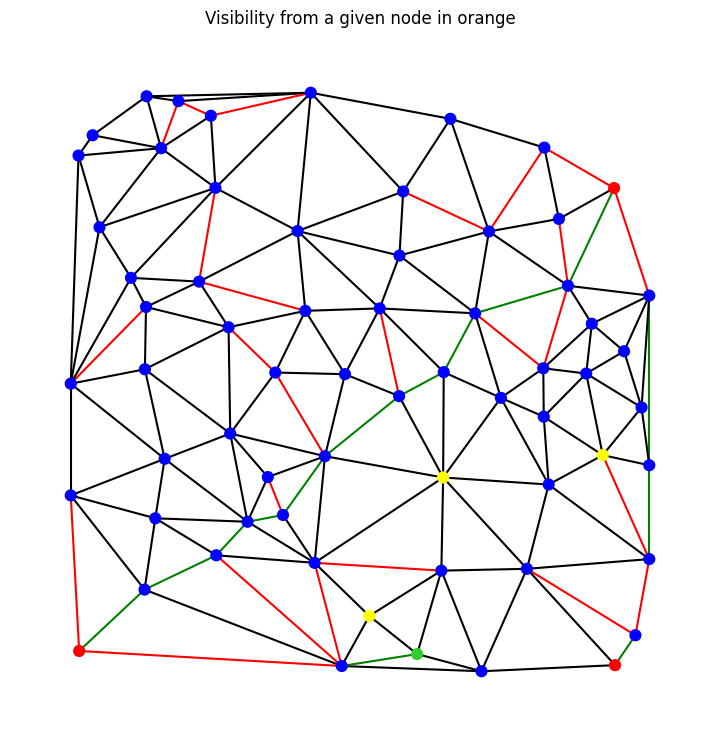

In [6]:
# This will serve as the real environment (env_graph now a ideal map for planning purposes)
# blocked_env_graph = block_edge_on_path(env_graph, shortest_path, block_per_section=3)
blocked_env_graph = block_edges_maintain_connectivity(env_graph, block_ratio=0.15)

extended_nodes = [node for node in blocked_env_graph.nodes() 
                  if blocked_env_graph.nodes[node].get('has_extended_visibility', True)]
non_extended_nodes = [node for node in blocked_env_graph.nodes() 
                  if blocked_env_graph.nodes[node].get('has_extended_visibility', False)]

blocked_edges = [edge for edge in blocked_env_graph.edges()
                 if blocked_env_graph.edges[edge].get('blocked', True)]

shortest_path_edges = {tuple(sorted((shortest_path[i], shortest_path[i+1]))) 
                   for i in range(len(shortest_path) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in blocked_edges:
        # Style for blocked edges: orange
        edge_color.append('red')
    elif edge_tuple in shortest_path_edges:
        # Style for edges on the shortest path but unblocked: green
        edge_color.append('green')
    else:
        # Style for unblocked edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=1.5,
    edge_color=edge_color
)

plt.title("Visibility from a given node in orange")
plt.show()

Let's first get an innocent shortest path agent to navigate this environment

In [7]:
# Remove all blocked edges from the blocked_env_graph
edges_to_remove = [(u, v) for u, v, data in blocked_env_graph.edges(data=True) if data.get('blocked', False)]
blocked_env_graph.remove_edges_from(edges_to_remove)

# Update the visible_edges for all nodes to reflect the removed edges
for node in blocked_env_graph.nodes():
    if "visible_edges" in blocked_env_graph.nodes[node]:
        current_visible = blocked_env_graph.nodes[node]["visible_edges"]
        # Remove any blocked edges from the visible_edges set
        updated_visible = set(current_visible) - set(edges_to_remove)
        blocked_env_graph.nodes[node]["visible_edges"] = list(updated_visible)

In [8]:
# This is for the agent operating on shortest path

path_1 = shortest_path.copy() # Start with the shortest path
target_nodes = hamiltonian_target_path.copy()  # All target nodes
env_graph1 = env_graph.copy() # Agent's world model (doesn't know any edges are blocked)

current_node = path_1[0]
next_target_index = 1 # since 0 is the source
index = 0

while index < len(path_1) - 1:
    next_node = path_1[index + 1]

    # Update the next_target_index 
    if current_node == target_nodes[next_target_index]:
        next_target_index += 1
    
    # Check out all the observable edges
    observable_edges = set(blocked_env_graph.nodes[current_node]["visible_edges"]) # From the actual blocked env graph
    assumed_observable_edges = set(env_graph1.nodes[current_node]["visible_edges"]) # From the agent's world model 
    blocked_edges = assumed_observable_edges - observable_edges
    
    if len(blocked_edges) > 0:
        # Remove blocked edges from agent's world model
        for edge in blocked_edges:
            u, v = edge
            if env_graph1.has_edge(u, v):
                print(f"From {current_node}, observed edge ({u}, {v}) is blocked. Removing from graph.")
                env_graph1.remove_edge(u, v)
                # Update the visibility mapping as well
                for node in env_graph1.nodes():
                    if "visible_edges" in env_graph1.nodes[node]:
                        current_visible = env_graph1.nodes[node]["visible_edges"]
                        # Remove any blocked edges from the visible_edges set
                        updated_visible = set(current_visible) - blocked_edges
                        env_graph1.nodes[node]["visible_edges"] = list(updated_visible)
        
        # Check if any blocked edge is in our current path
        path_edges = [(path_1[i], path_1[i+1]) for i in range(index, len(path_1) - 1)]

        # Create a set that includes both directions of blocked edges
        blocked_edges_both_directions = set()
        for u, v in blocked_edges:
            blocked_edges_both_directions.add((u, v))
            blocked_edges_both_directions.add((v, u))
        
        if any(edge in blocked_edges_both_directions for edge in path_edges):
            print(f"Blocked edge detected in planned path. Recalculating entire remaining path...")
            
            # Replan through ALL remaining targets
            remaining_targets = target_nodes[next_target_index:]
            new_path = [current_node]
            
            for target in remaining_targets:
                segment = nx.shortest_path(env_graph1, source=new_path[-1], target=target, weight="distance")
                new_path.extend(segment[1:])  # Append segment excluding the first node (already in new_path)
            
            # Replace the rest of path_1 with the new path
            path_1 = path_1[:index + 1] + new_path[1:]

    # Get the next node from the (possibly updated) path
    next_node = path_1[index + 1]
    
    # Now that we have a traversable path, just go to the next node in path
    print(f"Moving from {current_node} to {next_node}")
    current_node = next_node
    index += 1


Moving from 18 to 40
From 40, observed edge (40, 48) is blocked. Removing from graph.
From 40, observed edge (29, 40) is blocked. Removing from graph.
From 40, observed edge (8, 40) is blocked. Removing from graph.
Blocked edge detected in planned path. Recalculating entire remaining path...
Moving from 40 to 11
Moving from 11 to 48
From 48, observed edge (46, 48) is blocked. Removing from graph.
Moving from 48 to 11
Moving from 11 to 8
Moving from 8 to 30
Moving from 30 to 21
From 21, observed edge (14, 21) is blocked. Removing from graph.
Moving from 21 to 10
From 10, observed edge (10, 36) is blocked. Removing from graph.
Moving from 10 to 34
From 34, observed edge (34, 61) is blocked. Removing from graph.
Moving from 34 to 55
Moving from 55 to 53
From 53, observed edge (42, 53) is blocked. Removing from graph.
Moving from 53 to 60
From 60, observed edge (42, 60) is blocked. Removing from graph.
From 60, observed edge (27, 60) is blocked. Removing from graph.
Moving from 60 to 57
Fr

Let's now see the innocent agent's path

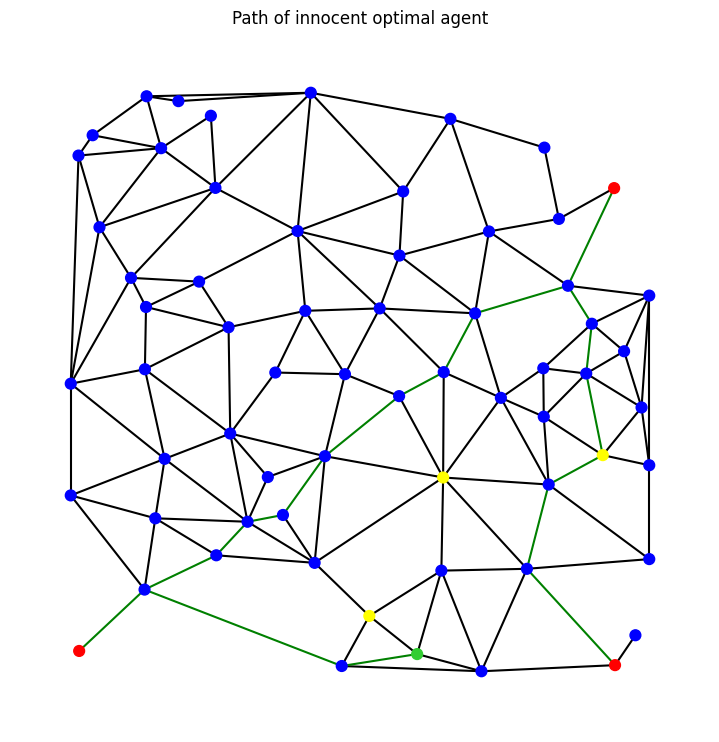

Total path length taken by the agent: 2.91


In [9]:
extended_nodes = [node for node in blocked_env_graph.nodes() 
                  if blocked_env_graph.nodes[node].get('has_extended_visibility', True)]
non_extended_nodes = [node for node in blocked_env_graph.nodes() 
                  if blocked_env_graph.nodes[node].get('has_extended_visibility', False)]

path_1_edges = {tuple(sorted((path_1[i], path_1[i+1]))) 
                   for i in range(len(path_1) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(blocked_env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in blocked_env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in blocked_env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in path_1_edges:
        # Style for edges on the shortest path but unblocked: green
        edge_color.append('green')
    else:
        # Style for unblocked edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    blocked_env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=1.5,
    edge_color=edge_color
)

plt.title("Path of innocent optimal agent")
plt.show()

total_path_length = 0.0
for i in range(len(path_1) - 1):
    u = path_1[i]
    v = path_1[i + 1]
    edge_data = env_graph.get_edge_data(u, v)
    if edge_data:
        total_path_length += edge_data.get('distance', 0.0)
print(f"Total path length taken by the agent: {total_path_length:.2f}")

Let's now see how our algorithm tackles the problem

In [10]:
# This is for the agent operating on our definition of the best path

env_graph2 = env_graph.copy()
path2_generator = RepeatedTopK(reward_ratio = 0.03, env_graph=env_graph2, target_graph=target_graph)

path_2 = path2_generator.find_best_path() # Start with the best path
target_nodes = hamiltonian_target_path.copy()  # All target nodes

current_node = path_2[0]
next_target_index = 1 # since 0 is the source
index = 0

while index < len(path_2) - 1:
    next_node = path_2[index + 1]

    # Update the next_target_index 
    if current_node == target_nodes[next_target_index]:
        next_target_index += 1
    
    # Check out all the observable edges
    observable_edges = set(blocked_env_graph.nodes[current_node]["visible_edges"]) # From the actual blocked env graph
    assumed_observable_edges = set(env_graph2.nodes[current_node]["visible_edges"]) # From the agent's world model 
    blocked_edges = assumed_observable_edges - observable_edges
    
    if len(blocked_edges) > 0:
        # Remove blocked edges from agent's world model
        for edge in blocked_edges:
            u, v = edge
            if env_graph2.has_edge(u, v):
                print(f"From {current_node}, observed edge ({u}, {v}) is blocked. Removing from graph.")
                env_graph2.remove_edge(u, v)
        
        # Update the visibility mapping as well
        for node in env_graph2.nodes():
            if "visible_edges" in env_graph2.nodes[node]:
                current_visible = env_graph2.nodes[node]["visible_edges"]
                # Remove any blocked edges from the visible_edges set
                updated_visible = set(current_visible) - blocked_edges
                env_graph2.nodes[node]["visible_edges"] = list(updated_visible)
        
        # Check if any blocked edge is in our current path
        path_edges = [(path_2[i], path_2[i+1]) for i in range(index, len(path_2) - 1)]

        # Create a set that includes both directions of blocked edges
        blocked_edges_both_directions = set()
        for u, v in blocked_edges:
            blocked_edges_both_directions.add((u, v))
            blocked_edges_both_directions.add((v, u))

        if any(edge in blocked_edges_both_directions for edge in path_edges):
            print(f"Blocked edge detected in planned path. Recalculating entire remaining path...")
            
            # Replan through ALL remaining targets
            remaining_targets = target_nodes[next_target_index:]
            new_path = [current_node]
            
            for target in remaining_targets:
                segment = path2_generator.alternate_path_online(new_path[-1], target)
                new_path.extend(segment[1:])  # Append segment excluding the first node (already in new_path)
            
            # Replace the rest of path_1 with the new path
            path_2 = path_2[:index + 1] + new_path[1:]

    # Get the next node from the (possibly updated) path
    next_node = path_2[index + 1]
    
    # Now that we have a traversable path, just go to the next node in path
    print(f"Moving from {current_node} to {next_node}")
    current_node = next_node
    index += 1


TSP Cycle: [12, 18, 48, 57]
Processing section from 18 to 48
Processing section from 48 to 57
Processing section from 57 to 12
Original Hamiltonian Path Reward: -2.01611080306541
Best Path Reward: -2.102992225434309
Moving from 18 to 41
From 41, observed edge (40, 48) is blocked. Removing from graph.
From 41, observed edge (25, 29) is blocked. Removing from graph.
From 41, observed edge (29, 40) is blocked. Removing from graph.
From 41, observed edge (8, 40) is blocked. Removing from graph.
Moving from 41 to 29
Moving from 29 to 8
Moving from 8 to 11
Moving from 11 to 48
From 48, observed edge (46, 48) is blocked. Removing from graph.
Moving from 48 to 11
Moving from 11 to 8
Moving from 8 to 29
Moving from 29 to 5
From 5, observed edge (9, 17) is blocked. Removing from graph.
From 5, observed edge (34, 61) is blocked. Removing from graph.
From 5, observed edge (10, 36) is blocked. Removing from graph.
Moving from 5 to 20
Moving from 20 to 42
From 42, observed edge (42, 60) is blocked. 

Let's plot our agent's path

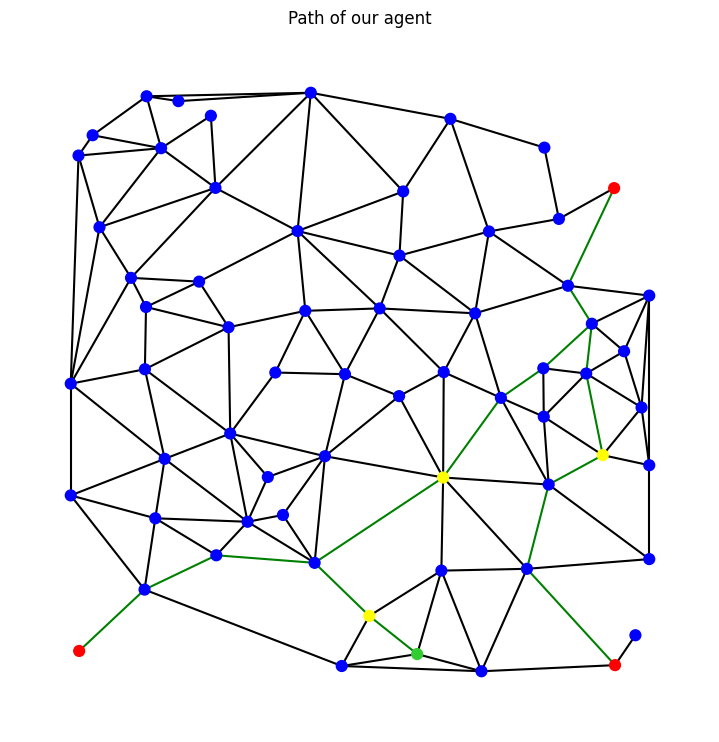

Total path length taken by the agent: 3.04


In [11]:
extended_nodes = [node for node in blocked_env_graph.nodes() 
                  if blocked_env_graph.nodes[node].get('has_extended_visibility', True)]
non_extended_nodes = [node for node in blocked_env_graph.nodes() 
                  if blocked_env_graph.nodes[node].get('has_extended_visibility', False)]

path_2_edges = {tuple(sorted((path_2[i], path_2[i+1]))) 
                   for i in range(len(path_2) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(blocked_env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in blocked_env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in blocked_env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in path_2_edges:
        # Style for edges on the shortest path but unblocked: green
        edge_color.append('green')
    else:
        # Style for unblocked edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    blocked_env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=1.5,
    edge_color=edge_color
)

plt.title("Path of our agent")
plt.show()

total_path_length = 0.0
for i in range(len(path_2) - 1):
    u = path_2[i]
    v = path_2[i + 1]
    edge_data = env_graph.get_edge_data(u, v)
    if edge_data:
        total_path_length += edge_data.get('distance', 0.0)
print(f"Total path length taken by the agent: {total_path_length:.2f}")